Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (5 chains in 1 job)
NUTS: [epsilon_interval__, beta_log__, alpha_interval__]
100%|██████████| 1100/1100 [00:31<00:00, 34.55it/s]
The acceptance probability does not match the target. It is 0.911300780176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898035305632, but should be close to 0.8. Try to increase the number of tuning steps.


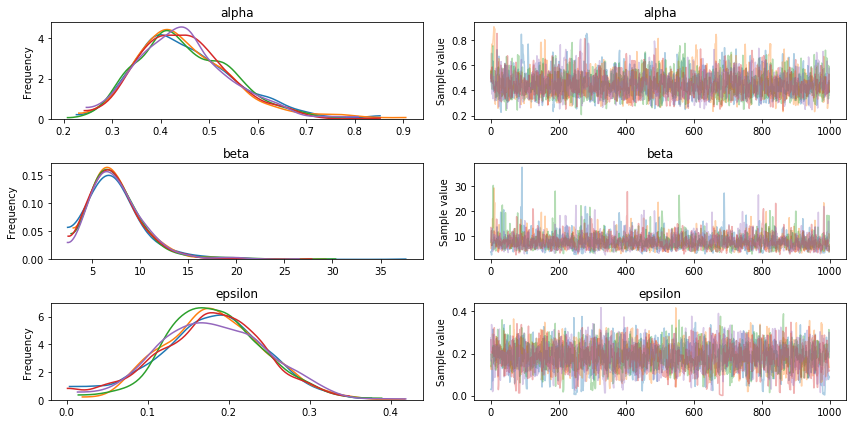

In [2]:
import numpy as np
import pandas as pd
import glob

import pymc3 as pm
import theano
import theano.tensor as T

import matplotlib.pyplot as plt


# Switches for this script
verbose = False
n_trials = -1

# Function definitions
def update_Q(reward, choice, Q_old, alpha):
    return Q_old + choice * alpha * (reward - Q_old)

def p_from_Q(Q_left, Q_right, beta, epsilon):
    p_left = 1 / (1 + T.exp(-beta * (Q_left - Q_right)))  # translate Q-values into probabilities using softmax
    return epsilon * 0.5 + (1 - epsilon) * p_left  # add epsilon noise
    

# Load to-be-modeled data
# True parameters:
# alpha == 0.39 (gen) or 0.42 (rec)
# beta == 5.18 (gen) or 8.43 (rec)
# epsilon == 0.10 (gen) or 0.19 (rec)
agent_data = pd.read_csv('C:/Users/maria/MEGAsync/SLCN/PSGenRecCluster/fit_par/PSsimple_flat135.csv')
right_choices = np.array(agent_data['selected_box'])[:n_trials]
left_choices = 1 - right_choices
rewards = agent_data['reward'].tolist()[:n_trials]

if verbose:
    print("Left choices:", left_choices)[:10]
    print("Right choices:", right_choices)[:10]
    print("Rewards:", rewards)[:10]

basic_model = pm.Model()
with basic_model:

    alpha = pm.Uniform('alpha', lower=0, upper=1)
    beta = pm.Lognormal('beta', mu=0, sd=1)
    epsilon = pm.Uniform('epsilon', lower=0, upper=1)
    Q_old = T.as_tensor_variable(0.499999)

    rewards = T.as_tensor_variable(rewards)  # reward (1) or no reward (0)
    left_choices = T.as_tensor_variable(left_choices)
    right_choices = T.as_tensor_variable(right_choices)

    Q_left, _ = theano.scan(fn=update_Q,
                            sequences=[rewards, left_choices],
                            outputs_info=[Q_old],
                            non_sequences=[alpha])
    Q_right, _ = theano.scan(fn=update_Q,
                             sequences=[rewards, right_choices],
                             outputs_info=[Q_old],
                             non_sequences=[alpha])
    
    p_left = p_from_Q(Q_left, Q_right, beta, epsilon)
    shifted_p_left = T.concatenate([[Q_old], p_left[:-1]])

    # The Bernoulli distribution describes the probability of successes (x=1) and failures (x=0)
    model_choices = pm.Bernoulli('model_choices', p=shifted_p_left, observed=left_choices)

    if verbose:
        beta_print = T.printing.Print('beta')(beta)[:10]
        alpha_print = T.printing.Print('alpha')(alpha)[:10]
        Q_left_print = T.printing.Print('Q_left')(Q_left)[:10]
        Q_right_print = T.printing.Print('Q_right')(Q_right)[:10]
        p_left_print = T.printing.Print('p_left')(p_left)[:10]
        shifted_p_left_print = T.printing.Print('shifted_p_left')(shifted_p_left)[:10]
        model_choices_print = T.printing.Print('model_choices')(model_choices)[:10]

    trace = pm.sample(1000, tune=100, chains=5, cores=1)

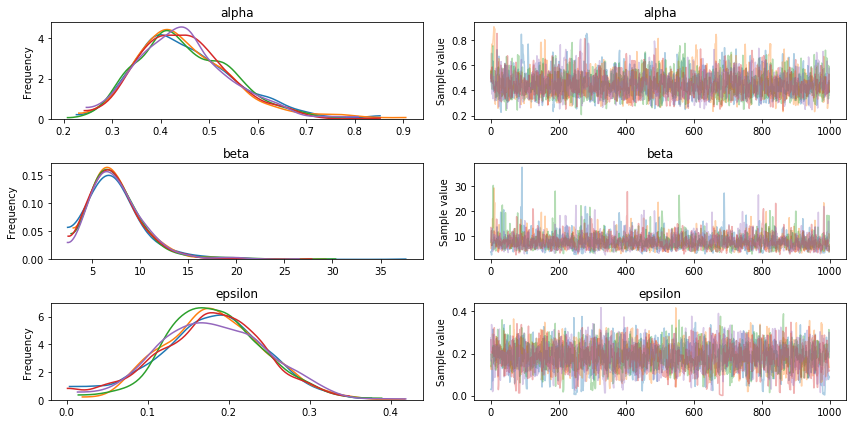

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.45,0.10,0.00,0.27,0.64,2215.25,1.0
beta,7.65,2.95,0.06,3.22,13.19,2459.02,1.0
epsilon,0.18,0.06,0.00,0.06,0.31,2287.14,1.0


In [8]:
# Results
# from pymc3 import model_to_graphviz
# model_to_graphviz(basic_model)
pm.traceplot(trace)
plt.show()
pm.summary(trace).round(2)